# L0,L1 smoothness and Frank-Wolfe on log regression. Version 3

Версия 2 пропущена, т.к. в ней почти ничего не было нового.

### Целевая функция

Будем оптимизировать функцию лог-регрессии
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \text{log}(1 + \text{exp}(-y_i (Ax)_i))
$$
, где $x \in \mathbb{R}^d$, $L= \text{max}_i \| A_i \|^2$, $L_0 = 0$, $L_1 = \text{max}_i \| A_i \|$ $(\| A_i \| >> 1)$

### Данные 
1) Попробуем генерацию на высоких размерностях. А так же на задачах, где количество фич намного меньше, чем размерность.
2) Низкообусловленные данные:
    1) высокая корреляция между столбцами
    2) последние колонки отшкалированы
    3) Случайно меняем знак у некоторых классов
3) Когда решение низкоразреженное. Попробуем для начала генерировать на $l_{\infty}$-шаре и на симплексе. Решения будут низкоразреженные, что позволит увидеть лучше, кто точно генерирует решение, а кто нет
4) Попробуем менять зашумленность классов: будем менять `margin`, `class_bias`, может быть еще `noise`


См. все в функции `hard_FW_log_reg_jax`

### Алгоритмы
В экспериментах сравниваются следующие методы:
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости (FW-L0_L1)
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости с логарифмическим шагом (FW-L0_L1_log)
- Алгоритм Франк-Вульфа классический (FW-stand) с shortest step

### Цель эксперимента

На всех предыдущих экспериментаз алгоритмы вели себя почти что одинаково. Я решил, что это потому что задачи слишком легкие, т.к. я заметил, что скорость сходимости там у них очень высокая: они быстро сходятся к решению и затем болтаются около нуля и не видно, кто из них лучше, а кто хуже.

Тут мы все же попытаемся выявить "Какой из алгоритмов будет быстрее всех сходится? При каких условиях? Почему?"

Новые "сложные" данные генерируются в функции `hard_FW_log_reg_jax`, предыдущая версия сохранена в `L0L1_FW_log_reg`, там уже есть половина от `hard_FW_log_reg_jax`, я там начал ее реализовывать, но не закончил.

Я уже не так оптимистичен по отношению к новым алгоритмам, так как мы меняем только длину шага, а сам алгоритм у нас особо никак не меняется. Но я все же думаю, что 
$$
\alpha_k = \frac{- (f(x_k)^\top d_k)}{(L_0^{(k)} + L_1^{(k)} \|\nabla f(x_k)\|) \|d_k\|^2 e}
$$
будет лучше себя вести на задачах с большими размерностями. Пчму? Птмчто в среднем константа $L_0^{(k)} + L_1^{(k)} \|\nabla f(x_k)\|$ у нее будет ниже, чем классическая$L$ и классический алгоритм будет падать, когда $L$ будет слишком высоким.

In [5]:
import sys
import os

# Get the parent directory of the notebook (2 levels up)
notebook_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

In [6]:
import numpy as np
import jax
import matplotlib.pyplot as plt

import accbpg

In [7]:
plt.rcParams.update({
    'font.size': 14,        # общий размер шрифта
    'font.family': 'serif',
    'axes.titlesize': 16,   # размер заголовков графиков
    'axes.labelsize': 15,   # размер подписей осей
    'legend.fontsize': 13,  # размер легенды
    'xtick.labelsize': 13,  # подписи на осях X
    'ytick.labelsize': 13   # подписи на осях Y
})

## Низкообусловленная задача

### Низкообусловленная задача. $L_2$-шар

Running for n_samples=2000, n_features=50

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.560e+03    4.545e-13    1.035e+02        1         0.2
   200    5.368e-01    5.796e+01    1.065e-11    2.424e+03      201         1.4
   400    5.363e-01    1.241e+02    2.343e-11    5.333e+03      401         2.2
   600    5.358e-01    8.000e+01    2.343e-11    5.333e+03      601         3.0
   800    5.354e-01    3.720e+02    5.154e-11    1.173e+04      801         3.9
  1000    5.352e-01    6.793e+01    2.343e-11    5.333e+03     1001         4.7
  1200    5.349e-01    6.502e+01    2.343e-11    5.333e+03     1201         5.8
  1400    5.348e-01    6.247e+01    2.343e-11    5.333e+03     1401         6.7
  1600    5.346e-01    6.019e+01    2.343e-11    5.333e+03     1601         7.5
  1800    5.344e-01    5.816e+01    2.343e-11    5.333e+03     1801         8.3

FW adaptive algorithm
     k      F(x) 

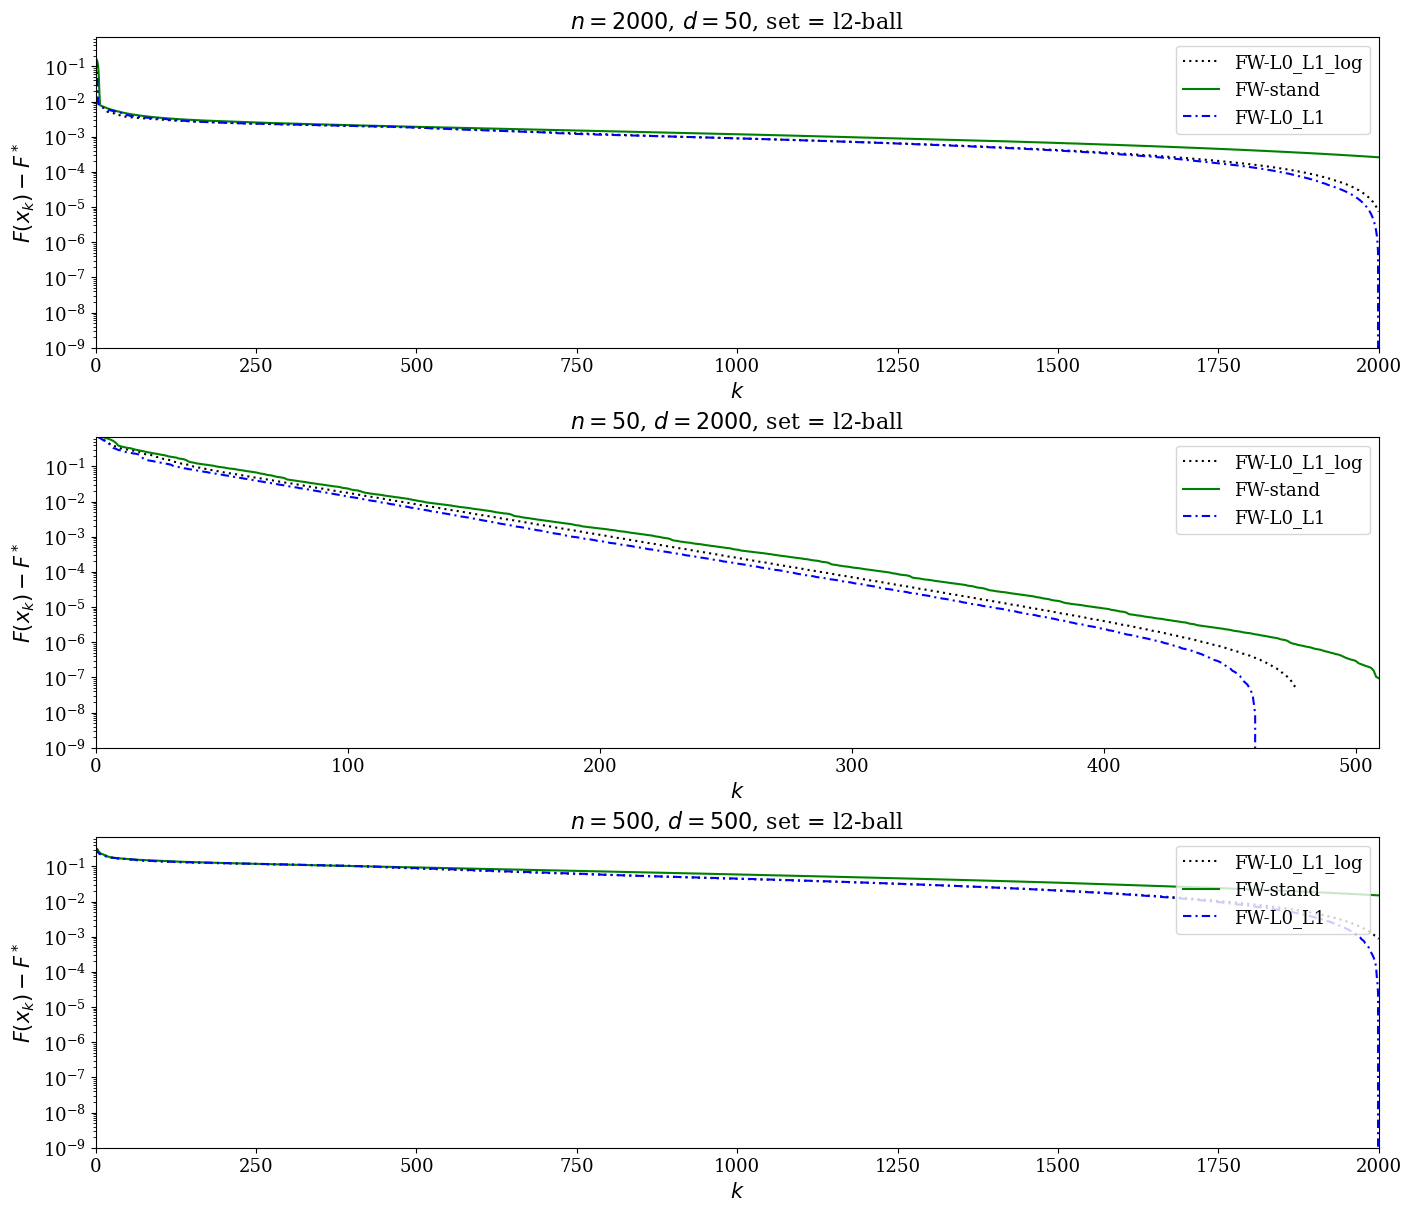

In [8]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(41)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log", r"FW-stand", r"FW-L0_L1"]

configs = [
    (2000, 50),
    (50, 2000),
    (500, 500),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.99,
                                                     col_scale=20.0,
                                                     flip_y=0.2,
                                                     noise=0.1)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_log, _, _, _ = accbpg.FW_alg_l0_l1_log_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=None, epsilon=eps, linesearch=True, verbskip=verbskip
        )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

### Низкообусловленная задача. $L_{\infty}$-шар

Running for n_samples=2000, n_features=50

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    5.342e+00    4.545e-13    7.983e+00        1         0.1
   200    4.525e-02    6.113e-02    1.000e-12    1.756e+01      201         0.9
   400    3.006e-02    1.423e-02    4.545e-13    7.983e+00      401         1.8
   600    2.274e-02    4.989e-02    2.200e-12    3.864e+01      601         2.6
   800    1.809e-02    1.189e-01    4.840e-12    8.500e+01      801         3.4
  1000    1.553e-02    6.212e-02    4.840e-12    8.500e+01     1001         4.2
  1200    1.362e-02    4.833e-03    4.545e-13    7.983e+00     1201         5.1
  1400    1.236e-02    1.085e-01    1.065e-11    1.870e+02     1401         5.9
  1600    1.135e-02    4.210e-02    4.840e-12    8.500e+01     1601         6.7
  1800    1.050e-02    1.596e-02    2.200e-12    3.864e+01     1801         7.5

FW adaptive algorithm
     k      F(x) 

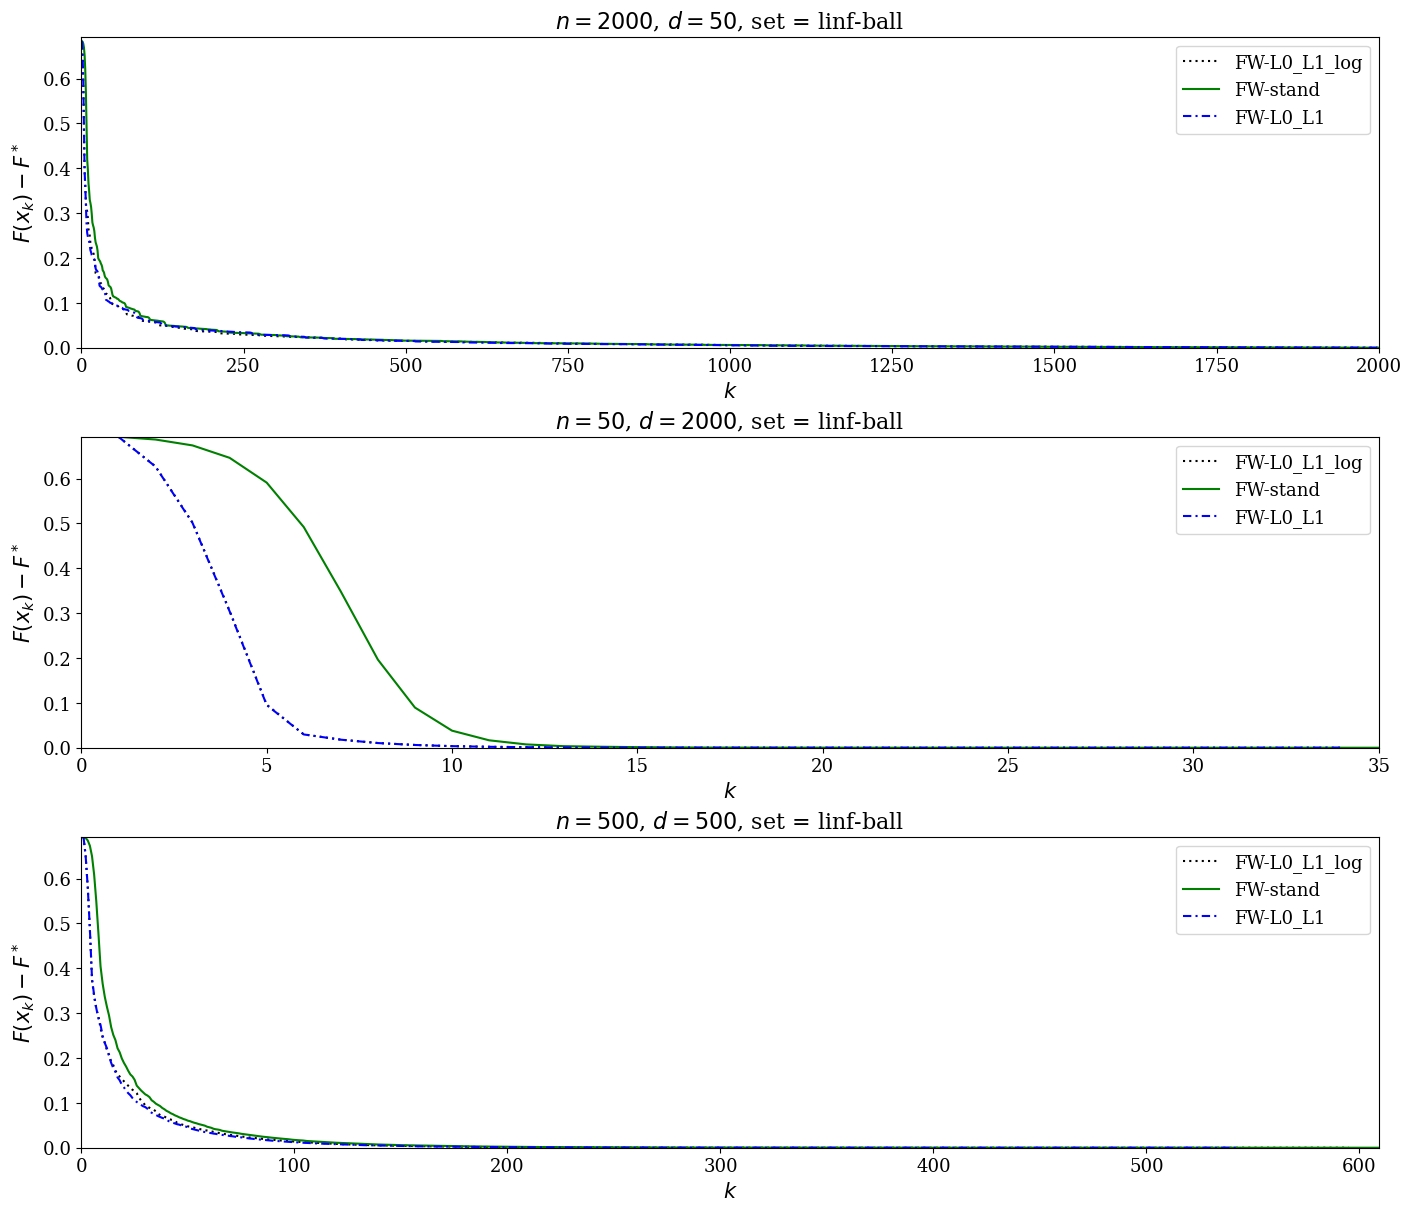

In [9]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,   # keep only shared x-axis
    sharey=False,  # allow separate y-limits
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(111)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log", r"FW-stand", r"FW-L0_L1"]

configs = [
    (2000, 50),
    (50, 2000),
    (500, 500),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="linf",
                                                     rho=0.9,
                                                     col_scale=1.0,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_linf_ball(ball_constrnt_radius)
    lmo_name = "linf-ball"

    x_l0l1_log, F_l0l1_log, _, _, _ = accbpg.FW_alg_l0_l1_log_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=None, epsilon=eps, linesearch=True, verbskip=verbskip
        )

    x_standard, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    x_l0_l1_step, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    ax = axes[i]
    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step))

    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters], ylim=[0, y_max], plotdiff=True, yscale="linear",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

### Низкообусловленная задача. Симплекс

Running for n_samples=2000, n_features=50

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    7.564e+02    4.545e-13    5.805e+01        1         0.1
   200    1.330e-01    6.811e-01    8.820e-15    1.126e+00      106         1.0
   400    1.317e-01    6.696e-01    8.820e-15    1.126e+00      223         1.8
   600    1.312e-01    6.653e-01    8.820e-15    1.126e+00      339         2.6
   800    1.310e-01    3.010e-01    4.009e-15    5.120e-01      455         3.4
  1000    1.309e-01    6.617e-01    8.820e-15    1.126e+00      572         4.3
  1200    1.308e-01    1.365e-01    1.822e-15    2.327e-01      688         5.1
  1400    1.307e-01    2.999e-01    4.009e-15    5.120e-01      807         5.9
  1600    1.307e-01    2.999e-01    4.009e-15    5.120e-01      925         6.7
  1800    1.306e-01    2.996e-01    4.009e-15    5.120e-01     1043         7.5

FW adaptive algorithm
     k      F(x) 

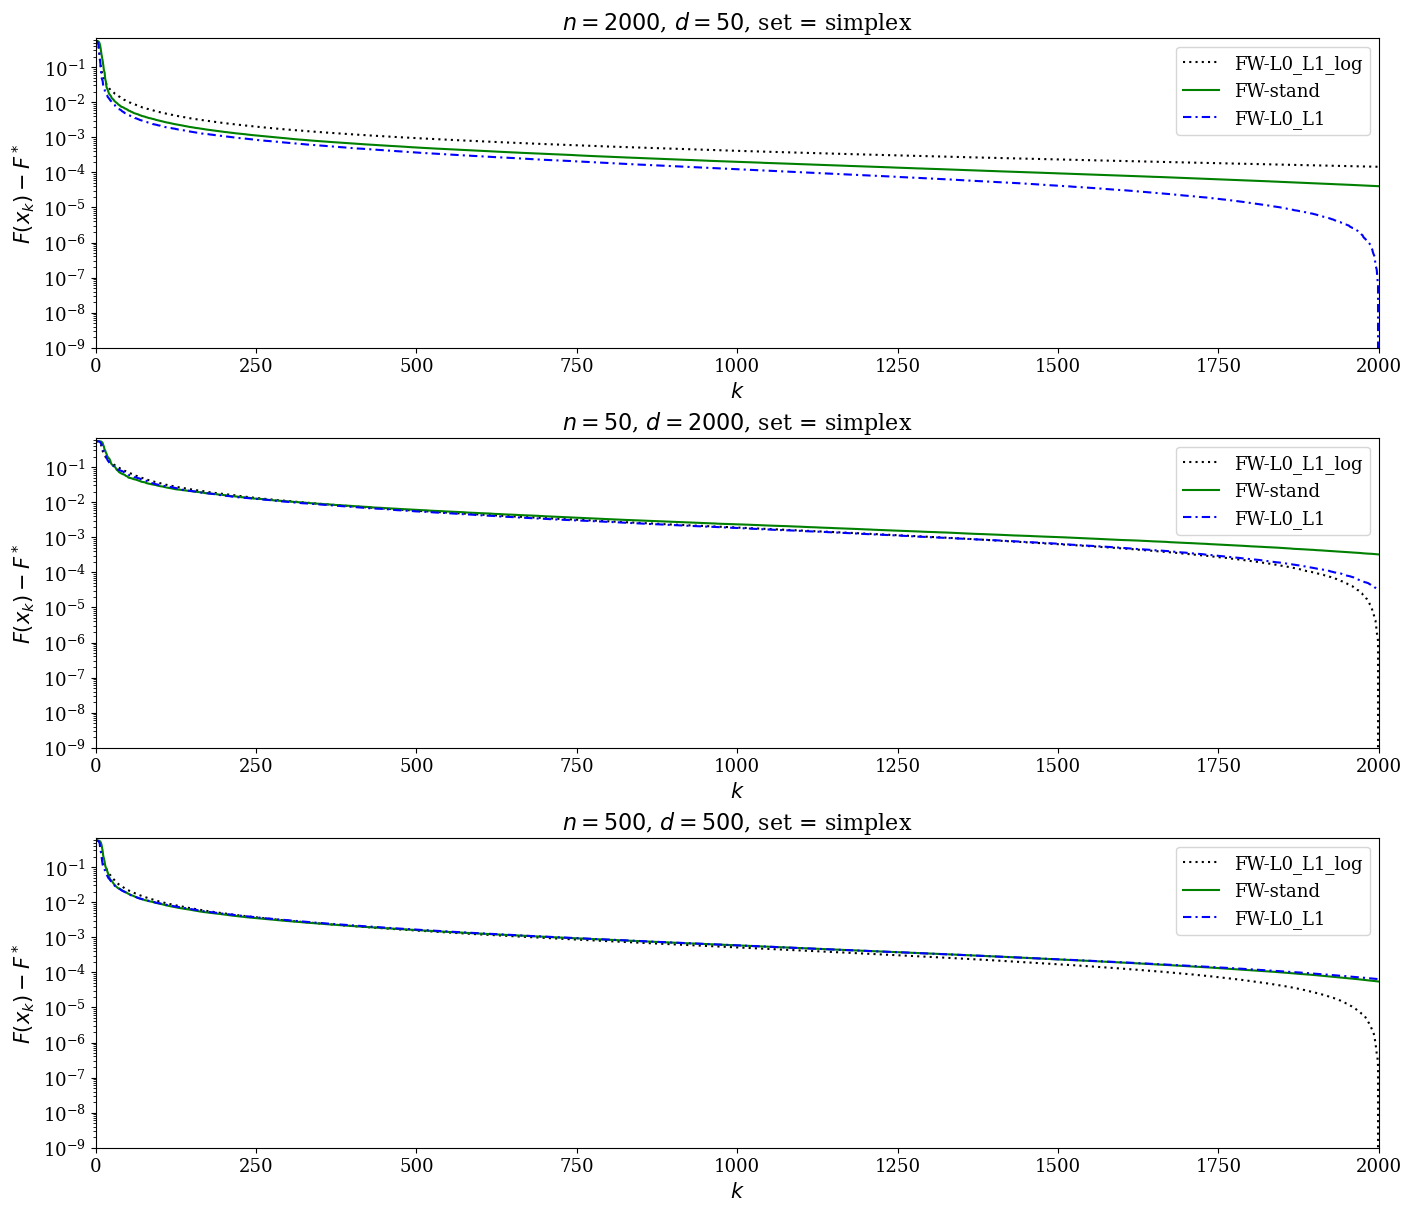

In [10]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,   # keep only shared x-axis
    sharey=False,  # allow separate y-limits
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(41)

l1_max_factor = 5
ball_constrnt_radius = 1

labels = [r"FW-L0_L1_log", r"FW-stand", r"FW-L0_L1"]

configs = [
    (2000, 50),
    (50, 2000),
    (500, 500),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="simplex",
                                                     k_sparse=25,
                                                     rho=0.99,
                                                     col_scale=10.0,
                                                     flip_y=0.0,
                                                     noise=0.01)
    lmo = accbpg.lmo_simplex(ball_constrnt_radius)
    lmo_name = "simplex"

    _, F_l0l1_log, _, _, _ = accbpg.FW_alg_l0_l1_log_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=None, epsilon=eps, linesearch=True, verbskip=verbskip
        )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    ax = axes[i]
    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step))

    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## Размерность сильно выше, чем число векторов. $L_2$-шар

Running for n_samples=50, n_features=500

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    6.656e+03    4.545e-13    1.681e+02        1         0.1
   200    9.909e-02    2.153e+02    1.000e-12    3.698e+02      201         0.9
   400    4.373e-02    2.558e+02    2.200e-12    8.135e+02      401         1.7
   600    2.024e-02    1.220e+02    2.200e-12    8.135e+02      601         2.5
   800    7.182e-03    1.576e+02    4.840e-12    1.790e+03      801         3.3
  1000    2.397e-03    3.313e+01    4.840e-12    1.790e+03     1001         4.1
  1200    7.888e-04    1.055e+01    4.840e-12    1.790e+03     1201         4.9
  1400    2.396e-04    2.388e-01    4.545e-13    1.681e+02     1401         5.7
  1600    7.054e-05    3.681e-01    2.200e-12    8.135e+02     1601         6.4
  1800    2.056e-05    2.947e-01    4.840e-12    1.790e+03     1801         7.2

FW adaptive algorithm
     k      F(x)  

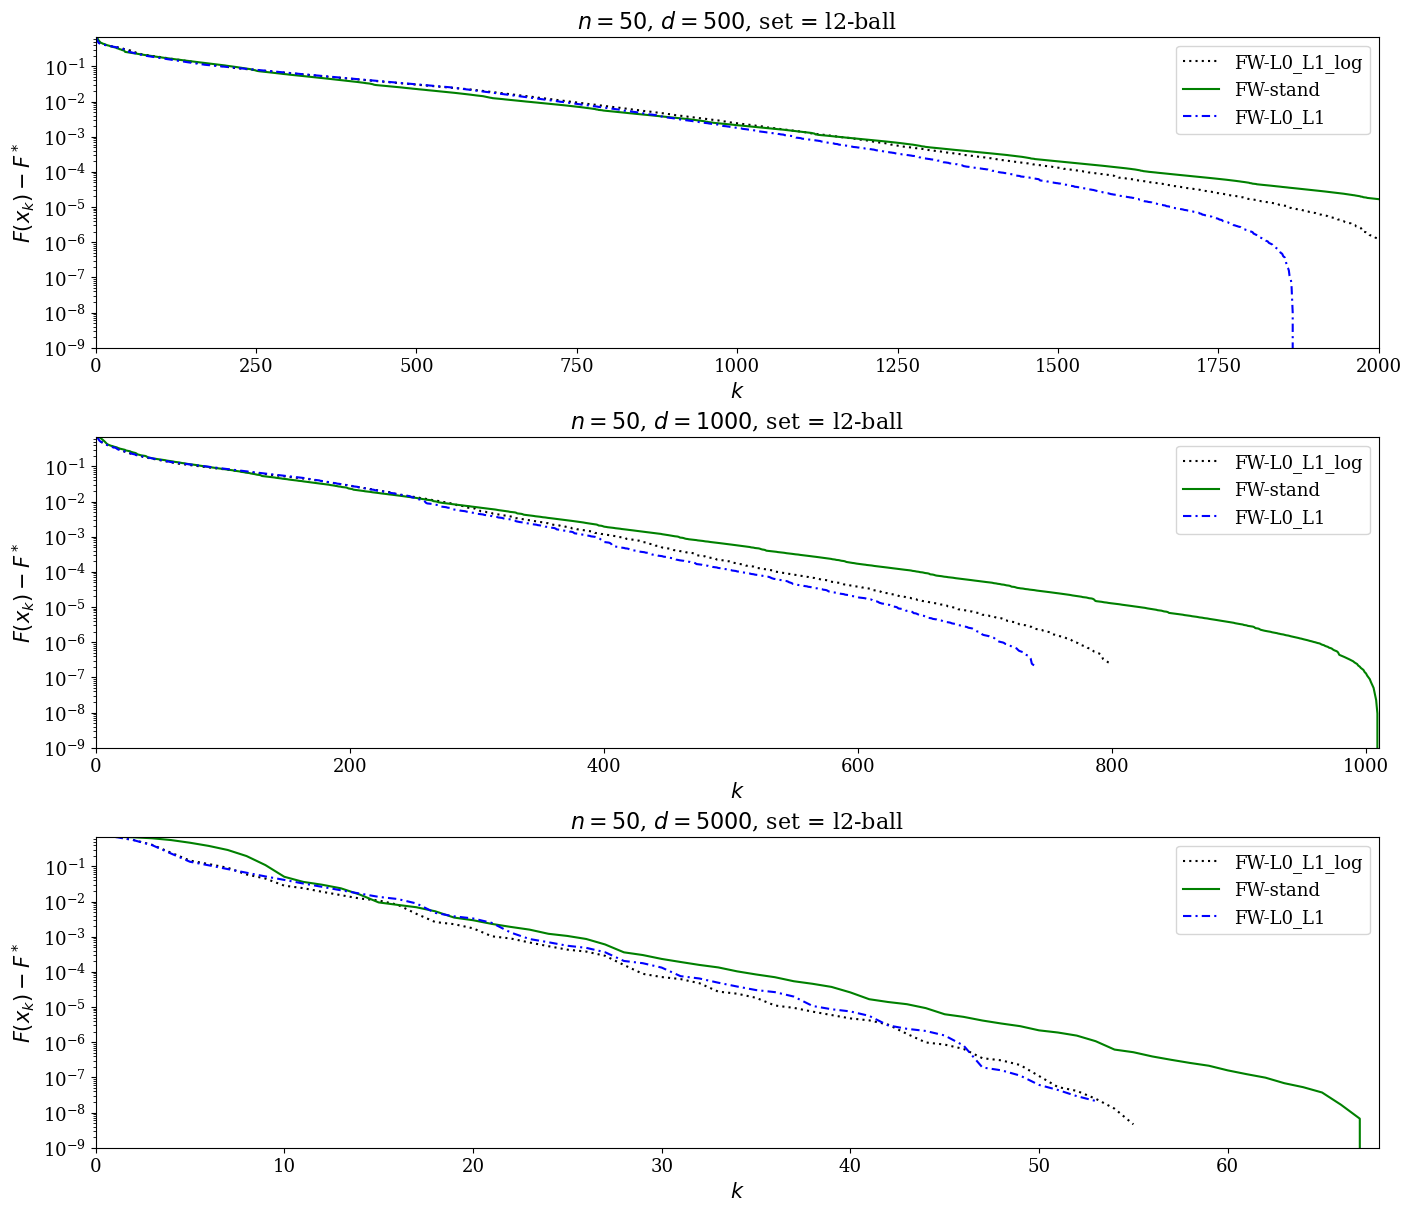

In [11]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(435)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log", r"FW-stand", r"FW-L0_L1"]

configs = [
    (50, 500),
    (50, 1000),
    (50, 5000),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.99,
                                                     col_scale=20.0,
                                                     flip_y=0.2,
                                                     noise=0.1)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_log, _, _, _ = accbpg.FW_alg_l0_l1_log_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=None, epsilon=eps, linesearch=True, verbskip=verbskip
        )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## Число векторов сильно выше, чем размерность. $L_2$-шар

Running for n_samples=500, n_features=50

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.058e+03    4.545e-13    7.829e+01        1         0.1
   200    5.304e-01    5.278e+01    4.840e-12    8.336e+02      201         0.9
   400    5.268e-01    3.443e+01    4.840e-12    8.336e+02      401         1.7
   600    5.245e-01    1.723e+02    2.343e-11    4.035e+03      601         2.5
   800    5.231e-01    1.785e+02    2.343e-11    4.035e+03      801         3.2
  1000    5.220e-01    1.170e+02    2.343e-11    4.035e+03     1001         4.0
  1200    5.213e-01    1.169e+02    2.343e-11    4.035e+03     1201         4.8
  1400    5.206e-01    1.168e+02    2.343e-11    4.035e+03     1401         5.5
  1600    5.200e-01    8.611e+01    2.343e-11    4.035e+03     1601         6.3
  1800    5.192e-01    9.201e+01    2.343e-11    4.035e+03     1801         7.1

FW adaptive algorithm
     k      F(x)  

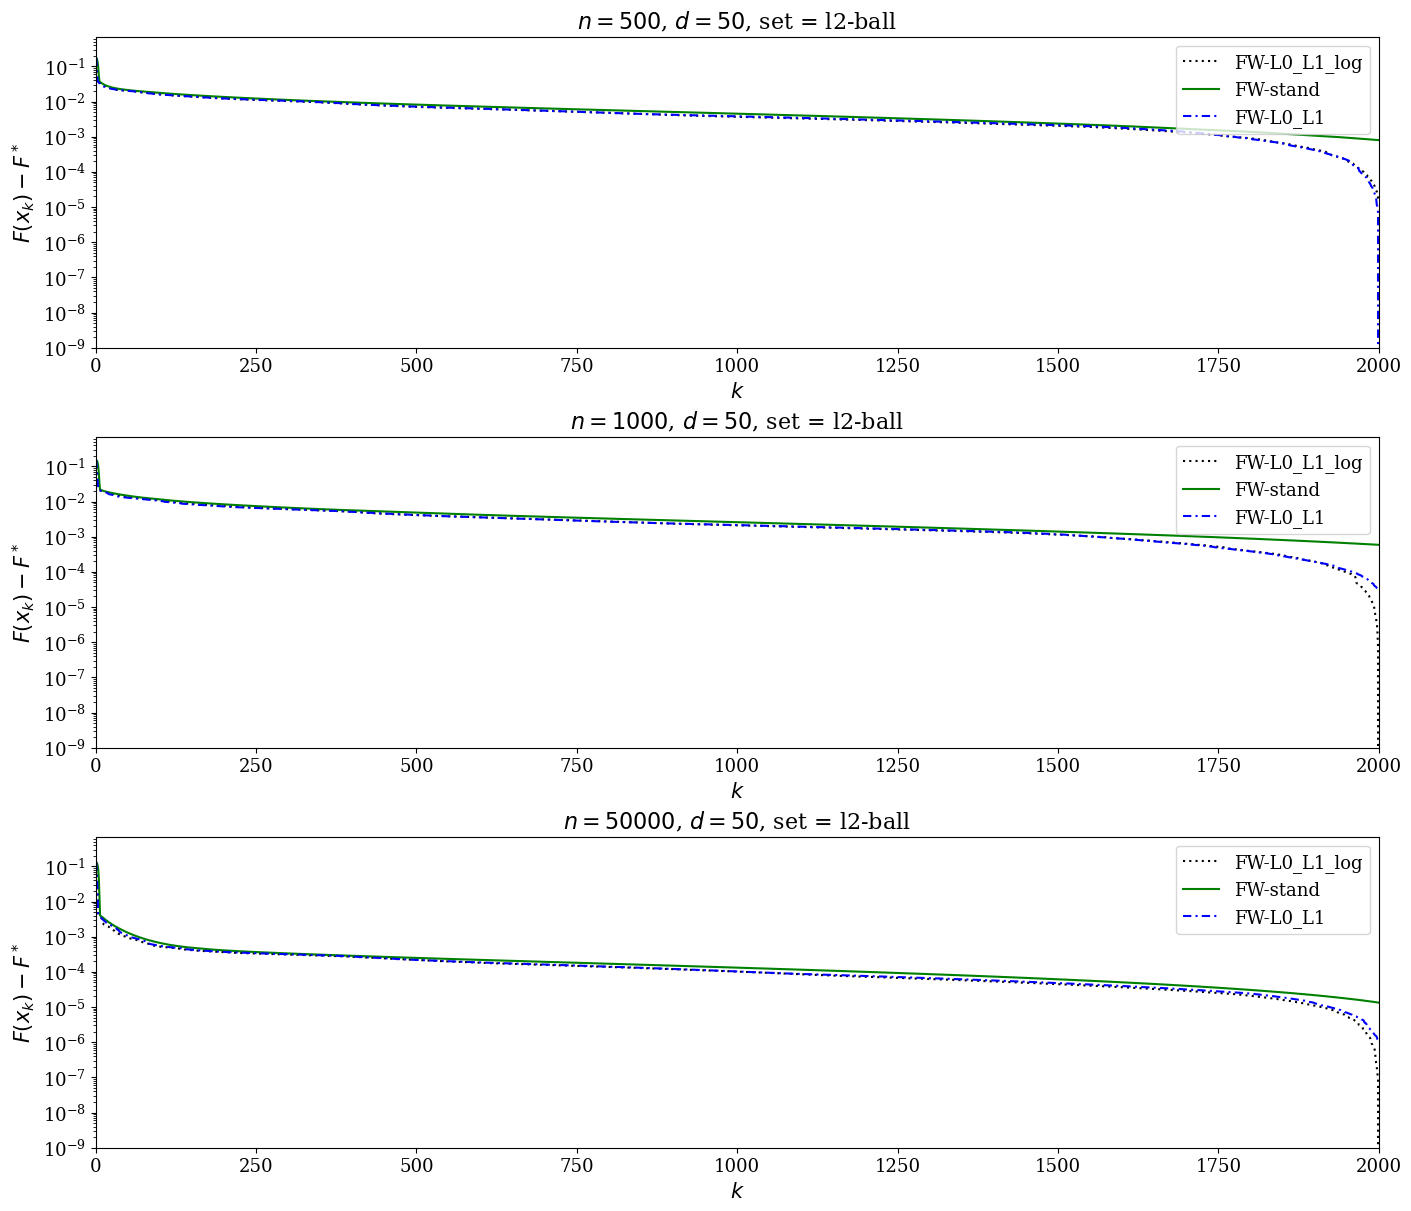

In [12]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(41)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log", r"FW-stand", r"FW-L0_L1"]

configs = [
    (500, 50),
    (1000, 50),
    (50000, 50),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.99,
                                                     col_scale=20.0,
                                                     flip_y=0.2,
                                                     noise=0.1)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_log, _, _, _ = accbpg.FW_alg_l0_l1_log_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=None, epsilon=eps, linesearch=True, verbskip=verbskip
        )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## Сильно сдвинутое решение. $L_2$-шар

Running for n_samples=2000, n_features=50

FW L0,L1 smooth logarithmic algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.561e+03    4.545e-13    1.035e+02        1         0.1
   200    5.369e-01    1.971e+02    2.343e-11    5.333e+03      201         1.0
   400    5.365e-01    1.240e+02    2.343e-11    5.333e+03      401         1.9
   600    5.360e-01    7.899e+01    2.343e-11    5.333e+03      601         2.7
   800    5.356e-01    7.666e+01    2.343e-11    5.333e+03      801         3.6
  1000    5.353e-01    6.732e+01    2.343e-11    5.333e+03     1001         4.5
  1200    5.351e-01    6.446e+01    2.343e-11    5.333e+03     1201         5.3
  1400    5.349e-01    6.198e+01    2.343e-11    5.333e+03     1401         6.2
  1600    5.348e-01    5.976e+01    2.343e-11    5.333e+03     1601         7.1
  1800    5.346e-01    6.034e+01    2.343e-11    5.333e+03     1801         7.9

FW adaptive algorithm
     k      F(x) 

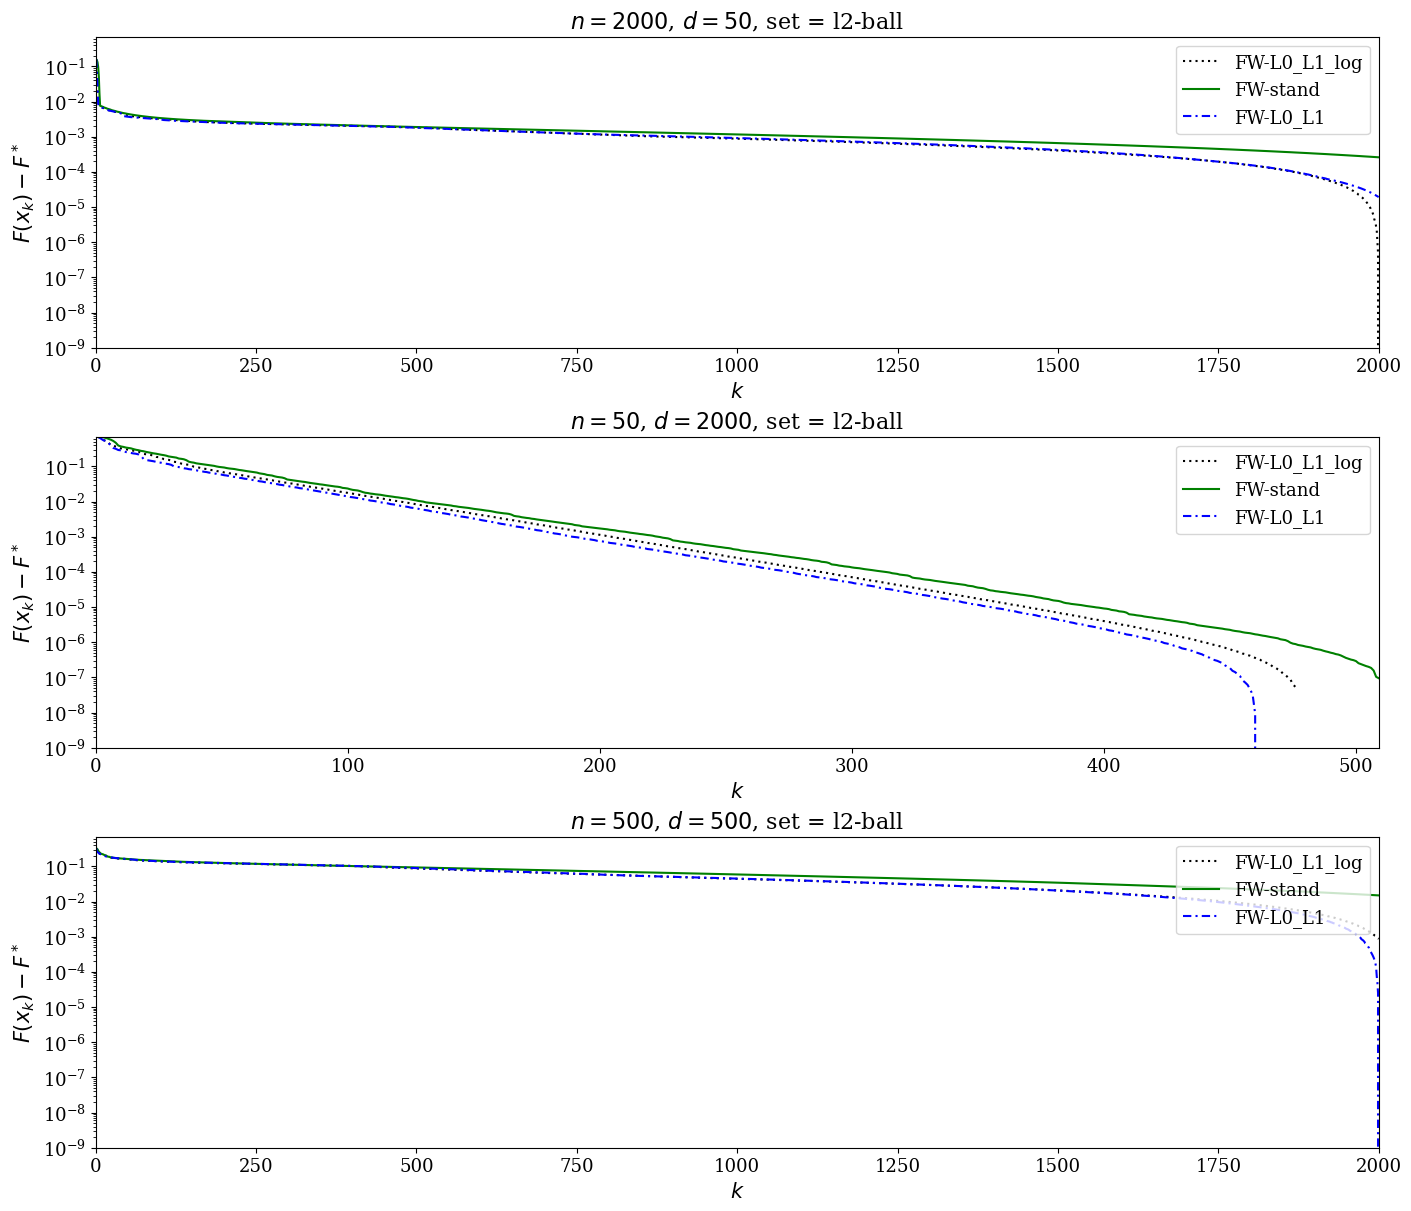

In [13]:
fig, axes = plt.subplots(
    3, 1,
    figsize=(14, 12),  # увеличенная ширина и особенно высота
    sharex=False,
    sharey=False,
    constrained_layout=True
)


eps = 1e-8
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

key = jax.random.key(41)

l1_max_factor = 5
ball_constrnt_radius = 25


labels = [r"FW-L0_L1_log", r"FW-stand", r"FW-L0_L1"]

configs = [
    (2000, 50),
    (50, 2000),
    (500, 500),
]

for i, (n_samples, n_features) in enumerate(configs):
    print(f"Running for n_samples={n_samples}, n_features={n_features}")
    f, h, L, L0, L1, x0, X_data, y_true = accbpg.hard_FW_log_reg_jax(key, 
                                                     n_samples, n_features, 
                                                     radius=ball_constrnt_radius, 
                                                     domain="l2",
                                                     rho=0.99,
                                                     col_scale=20.0,
                                                     flip_y=0.2,
                                                     margin=350.5,
                                                     class_bias=1.0,
                                                     noise=0.1)
    lmo = accbpg.lmo_l2_ball(ball_constrnt_radius)
    lmo_name = "l2-ball"

    _, F_l0l1_log, _, _, _ = accbpg.FW_alg_l0_l1_log_step(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, 
            L1_max=None, epsilon=eps, linesearch=True, verbskip=verbskip
        )

    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    _, F_l0_l1_step, _, _ = accbpg.FW_alg_L0_L1_step(
        f, h, L0, L1, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo, ls_ratio=ls_ratio,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    y_min = min(np.min(F_l0l1_log), np.min(F_standard), np.min(F_l0_l1_step))
    y_max = max(np.max(F_l0l1_log), np.max(F_standard), np.max(F_l0_l1_step))

    max_executed_iters = max(len(F_l0l1_log), len(F_standard), len(F_l0_l1_step))

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1_log, F_standard, F_l0_l1_step],
        labels,
        xlim=[0, max_executed_iters],
        ylim=[1e-9, y_max],  # Adjusted for log scale
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$",
        ylabel=r"$F(x_k) - F^*$",
        legendloc="upper right"
    )

    ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, set = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

## Выводы



Генерируемая задача для лог-регрессии слишком простая, т.к. я заметил, что скорость сходимости там у них очень высокая: они быстро сходятся к решению на первых итерациях и затем болтаются около нуля и не видно, кто из них лучше, а кто хуже. Поэтому было принято решение генерировать низкообусловленные задачи с шумом и шкалированием по колонкам.

По экспериментам четко видно превосходство предложенного алгоритма. Оно небольшое, но мы и не предложили что-то чильно новое тут, а всего лишь регулировку длиные шага.